In [20]:
import pandas as pd
import geopandas as gpd
import numpy as np
from preprocess import clean_police_dataset
import shapely
from shapely.geometry import point
import seaborn as sns
import matplotlib.pyplot as plt
# Anita Sun

In [2]:
def tract_merger(pol_filepath, shapefile_path):
    ''' 
    takes in the police homicide filepath and the census tract shapefile path
    and merges them together for that particular state

    pol_filepath: (str) file path for the police homicide csv
    shapefile_path: (str) file path for the census tract polygons shapefile

    returns:
    geo_joined_df: (GeoPandas Dataframe) a geopandas dataframe
    '''
    gdf = gpd.read_file(shapefile_path)
    pol_df = clean_police_dataset(pol_filepath)
    pol_df['geometry'] = gpd.points_from_xy(pol_df['longitude'], pol_df['latitude'])
    pol_gdf = gpd.GeoDataFrame(pol_df, geometry='geometry', crs="EPSG:4326")
    geo_joined_df = gpd.sjoin(gdf.to_crs(crs='EPSG:26916'), pol_gdf.to_crs(crs='EPSG:26916'))
    geo_joined_df = geo_joined_df[['GEOIDFQ','name', 'age', 'gender', 'race',
       'date', 'street_address', 'city', 'state', 'zip', 'county',
       'agency_responsible', 'ori', 'cause_of_death', 'circumstances',
       'disposition_official', 'officer_charged', 'news_urls',
       'signs_of_mental_illness', 'allegedly_armed', 'wapo_armed',
       'wapo_threat_level', 'wapo_flee', 'geography', 'encounter_type',
       'initial_reason', 'call_for_service', 'tract',
       'hhincome_median_census_tract', 'latitude', 'longitude',
       'pop_total_census_tract', 'pop_white_census_tract',
       'pop_black_census_tract', 'pop_native_american_census_tract',
       'pop_asian_census_tract', 'pop_pacific_islander_census_tract',
       'pop_other_multiple_census_tract', 'pop_hispanic_census_tract',
       'lat_long', 'month', 'day', 'year']]
    # renaming GEOIDFQ to GEO_ID so we can merge with ACS later
    geo_joined_df.rename(columns={'GEOIDFQ':'GEO_ID'}, inplace=True)
    # correcting year column to dtype int64
    geo_joined_df['year'] = geo_joined_df['year'].astype(int)
    # correcting zip column to dtype int64    

    return geo_joined_df

In [3]:
def booleaner(obj, list_like):
    ''' 
    returns 1 if obj is found in list_like, else returns zero
    obj: (anything)
    list_like: (listlike)
    '''
    if obj in list_like:
        return 1
    else:
        return 0

In [4]:
def attr_merger(geo_joined_df, census_file_path, county):
    ''' 
    takes a geo_df, census_file_path, and year and merges them all together
    geo_joined_df: (GeoPandasDataFrame) a sjoin of a state's .shp shapefile and the original police homicide csv
        has column 'GEOIDFQ' renamed to 'GEO_ID' for merging;
    census_file_path: file path for census tract demographic information, should be csv, year = 2013
    county: (str) county in question
    
    returns:
        df: a pd DataFrame containing census demographic data and a column that contains boolean val for pol homicide
    '''
    df = pd.read_csv(census_file_path)
    # dropping row index zero because it contains column name information and not data
    df = df.drop(index=0, axis=0)

    # converting all possible columns to float for later regression/classification analysis
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            continue
        
    df['in_county'] = df.NAME.str.extract(r'\s*([\w\s]+ County)', expand=False)
    
    if type(county)==str:
        df = df[df['in_county'] == county]
    if type(county)==list:
        df = df[df['in_county'].isin(county)]        
    df['target'] = df.apply(
		lambda x: booleaner(x['GEO_ID'], geo_joined_df['GEO_ID'].values),
        axis=1
	)

    # performing merge on the 'GEO_ID' column with the sjoined tract polygon/homicide df
    return df

In [5]:
geo_ny = tract_merger('police_data.csv', 'new_york_shapefiles/tl_2023_36_tract.shp')
geo_il = tract_merger('police_data.csv', 'illinois_shapefiles/tl_2023_17_tract.shp')
geo_ca = tract_merger('police_data.csv', 'california_shapefiles/tl_2023_06_tract.shp')

Text(0.5, 1.0, 'Police Homicides by Year - New York')

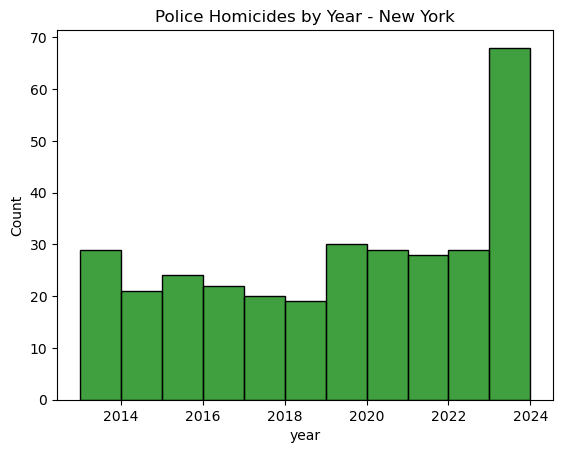

In [31]:
sns.histplot(geo_ny['year'],
             color='g',
             binwidth=1)
plt.title('Police Homicides by Year - New York')

Text(0.5, 1.0, 'Police Homicides by Year - California')

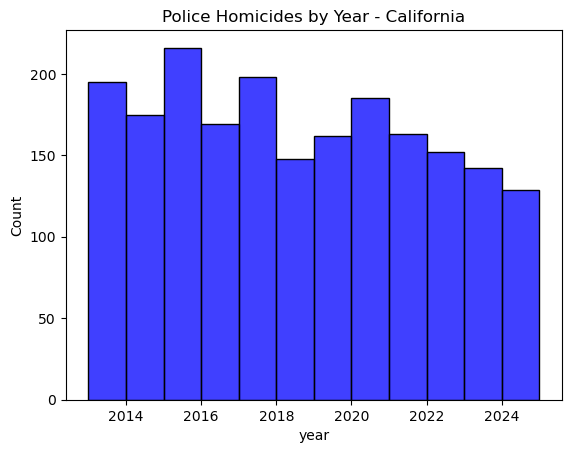

In [29]:
sns.histplot(geo_ca['year'],
             color='b',
             binwidth=1)
plt.title('Police Homicides by Year - California')

Text(0.5, 1.0, 'Police Homicides by Year - Illinois')

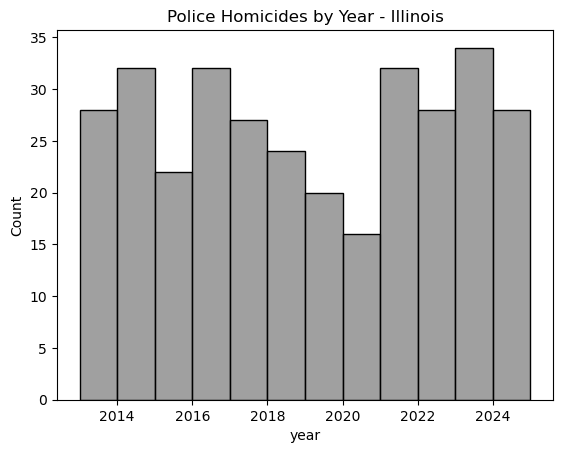

In [30]:
sns.histplot(geo_il['year'],
             color='grey',
             binwidth=1)
plt.title('Police Homicides by Year - Illinois')

In [6]:
df_ny = attr_merger(geo_ny, 'census_2013/ny_2013.csv', county=['Bronx County', 'Kings County', 'New York County', 'Queens County', 'Richmond County'])
df_il = attr_merger(geo_il, 'census_2013/il_2013.csv', county='Cook County')
df_ca = attr_merger(geo_ca, 'census_2013/ca_2013.csv', county='Los Angeles County')

/tmp/ipykernel_25604/3136482841.py:12: DtypeWarning: Columns (2,3,58,59,82,83,124,125,126,127,128,129,154,155,156,157,158,159,214,215,216,217,218,219,232,233,234,235,236,237,250,251,252,253,254,255,268,269,270,271,272,273,354,355,356,358,359,362,363,366,367,370,371,374,375,378,379,382,383,386,387,390,391,394,395,398,399,402,403,406,407,410,411,414,415,422,423,426,427,430,431,434,435,438,439,440,442,443,446,447,450,451,452,454,455,458,459,462,463,464,466,467,470,471,474,475,478,479,482,483,486,487,490,491,494,495,498,499,502,503,506,507,510,511,514,515,518,519,522,523,526,527,530,531,534,535,538,539,542,543,546,547,550,551,554,555,558,559,562,563,566,567,570,571,574,575,578,579,582,583,584,586,587,590,591,594,595,598,599,602,603,606,607,610,611,612,614,615,618,619,622,623,626,627,630,631,634,635,638,639,642,643,646,647,650,651,654,655,658,659,662,663,666,667,670,671,674,675) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(census_file_path)
/t

In [26]:
df_ny.to_csv('final_merge_ny.csv')
df_ca.to_csv('final_merge_ca.csv')
df_il.to_csv('final_merge_il.csv')

In [41]:
colname_dic = {"S1501_C01_014E": "highschool degree over higher rate", 
               "S1903_C02_001E": "household median income", 
               "S1903_C02_002E": "white household median income",
               "S1903_C02_003E": "black household median income",
               "DP05_0032PE": "white race rate"
               "DP05_0033PE" "black race rate"
               }

In [59]:
df_ny = df_ny[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE", "target"]]
df_ny.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)
df_il = df_il[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE", "target"]]
df_il.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)
df_ca = df_ca[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE", "target"]]
df_ca.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)

/tmp/ipykernel_25604/3691067691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ny.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)
/tmp/ipykernel_25604/3691067691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_il.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)
/tmp/ipykernel_25604/3691067691.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [60]:
print(f'Desc for New York', '\n')
for col in colname_dic.keys():
        print(colname_dic[col],'\n',df_ny[col].describe())
        print('\n')

Desc for New York 

highschool degree over higher rate 
 count      2127
unique      495
top       100.0
freq         17
Name: S1501_C01_014E, dtype: object


household median income 
 count      2109
unique     2016
top       63750
freq          4
Name: S1903_C02_001E, dtype: object


white household median income 
 count      1993
unique     1840
top       61250
freq          6
Name: S1903_C02_002E, dtype: object


black household median income 
 count      1464
unique     1372
top       81250
freq          5
Name: S1903_C02_003E, dtype: object


white race rateDP05_0033PEblack race rate 
 count     2127
unique     863
top          0
freq        16
Name: DP05_0032PE, dtype: object




In [ ]:
print(f'Desc for California', '\n')
for col in colname_dic.keys():
        print(colname_dic[col],'\n',df_ca[col].describe())
        print('\n')

In [61]:
print(f'Desc for Illinois', '\n')
for col in colname_dic.keys():
        print(colname_dic[col],'\n',df_il[col].describe())
        print('\n')

Desc for Illinois 

highschool degree over higher rate 
 count     1315
unique     418
top       90.1
freq        12
Name: S1501_C01_014E, dtype: object


household median income 
 count      1315
unique     1268
top       55000
freq          5
Name: S1903_C02_001E, dtype: object


white household median income 
 count      1134
unique     1082
top       58750
freq          4
Name: S1903_C02_002E, dtype: object


black household median income 
 count      869
unique     835
top       2500
freq         5
Name: S1903_C02_003E, dtype: object


white race rateDP05_0033PEblack race rate 
 count     1315
unique     644
top        0.0
freq        33
Name: DP05_0032PE, dtype: object


